# Calucate Average Precision
In the case of binary classification, **precision** and **recall** are two commonly used metrics. Precision is a performance measure of positive predictions, whereas recall is a performance measure of the whole positive part of a dataset.
These two metrics are defined as:
$$
precision = \frac{TP}{TP + FP}\\
recall = \frac{TP}{TP + FN}\\
$$
Sometimes it's not convinient to perform model selection under two metrics, so **average precision(AP)** is come up with to unify these two basic evaluation measures. Each AP value is associated with a precision-recall curve(PRC). 
Intuitively, we could change the threshold of the binary classifier, which may produce a different result of (precision, recall) pair. So if we plot all these (precision, recall) points under different threhold values, we'll get a so-called precision-recall curve:
![]()
Mathematically, average precision is defined as:
$$
AP = \int_0^1 p(r)dr
$$
where $p(r)$ gives the precision value at a given recall value. So AP is exacly the area under the curve(AUC).
Speaking of calculating the AUC, there are mainly two different versions:
- Version one: Directly connect two adjacent (precision, recall) points and compute the area under the line segments.
- Version two: Use interpolated precision value by setting precision for recall $r$ where:
$$
p(r) = max_{r'>r } p(r')
$$
These notebook focuses on how to compute these two different versions of AP. Refer to [here](https://sanchom.wordpress.com/tag/average-precision/) and [here](https://classeval.wordpress.com/introduction/introduction-to-the-precision-recall-plot/) for detailed explanation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Random Data

In [2]:
np.random.seed(5)

n = 10
score = np.random.randn(n)                # score
gt = np.random.randint(2, size=(n,))      # ground truth   

## Precision-Recall Pairs
As we can see from the definition of recall, the denominator is ther number of positive examples, which is a constant no matter how we choose our threshold value. As a result, the recall value depends only on the number of true positives. So if we steadily decrease the threhold value from 1 down to 0, we would gradually predict every example as positive and thus the recall will also go up util it reaches 1. 
In order to simplify the calculation of this process, we first sort the output scores(sometimes probability values) in descending order and decrease the threshold value each time to just include one more example. Here we first show how to compute the (precision, recall) pairs.

In [3]:
def precision_recall_pairs(score, gt):
    si = np.argsort(-score)   # sort in descending order
    tp = (gt[si] == 1)
    fp = (gt[si] == 0)
    tp = np.cumsum(tp)
    fp = np.cumsum(fp)
    prec = tp / (tp + fp)
    rec = tp / np.sum(gt)
    return prec, rec

## Version One
This version has already been implemented in sklearn package, so we could import from it to varify the correctness of our implementation.

In [4]:
from sklearn.metrics import average_precision_score

def direct_precision_recall_pairs(score, gt):
    prec, rec = precision_recall_pairs(score, gt)
    # include another pair where precision=1 and recall=0
    prec = np.r_[1, prec]
    rec = np.r_[0, rec]
    return prec, rec

def average_precision_v1(score, gt):
    """
    Average precision version one.
    ---
    Arguments:
    score: np.array, with shape(n_examples,), confidence of the predicitions, could either be 
    score values(logits) or probability values.
    gt: np.array, same shape with `score`, contains only 1 or 0.
    ---
    Returns:
    ap: float, between[0, 1], the average precision value.
    """
    prec, rec = direct_precision_recall_pairs(score, gt)
    ap = np.sum(0.5 * (prec[:-1] + prec[1:]) * (rec[1:] - rec[:-1]))  # area of trapezoids
    return ap

In [5]:
ap_v1 = average_precision_v1(score, gt)
ap_official = average_precision_score(gt, score)
assert abs(ap_v1 - ap_official) < 1e-8, "<<ERROR>>"
print('Average precision(v1):       %.5f' % ap_v1)
print('Average precision(expected): %.5f' % ap_official)

Average precision(v1):       0.63964
Average precision(expected): 0.63964


## Version Two
There's no official implementation of the interpolated average precision. However, the PASCAL competition does provide a matlab version in their development toolkit, which could be found be [here](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCdevkit_18-May-2011.tar). So we may test our result against the matlab version. The matlab code is as follows:
```Matlab
%%%%%%%%%%%% Helper Function %%%%%%%%%%%%%%%
function ap = VOCap(rec,prec)

mrec=[0 ; rec ; 1];
mpre=[0 ; prec ; 0];
for i=numel(mpre)-1:-1:1
    mpre(i)=max(mpre(i),mpre(i+1));
end
i=find(mrec(2:end)~=mrec(1:end-1))+1;
ap=sum((mrec(i)-mrec(i-1)).*mpre(i));

%%%%%%%%%%%%% Actual Computation %%%%%%%%%%%%
[so,si]=sort(-score);    
tp=gt(si)>0;
fp=gt(si)<0;
fp=cumsum(fp);
tp=cumsum(tp);

rec=tp/sum(gt>0);
prec=tp./(fp+tp);

ap=VOCap(rec,prec);
```

In [6]:
def interpolated_precision_recall_pairs(score, gt):
    prec, rec = precision_recall_pairs(score, gt)
    prec = np.r_[0, prec, 0]
    rec = np.r_[0, rec, 1]
    # calcuate the interpolated precision value
    for i in reversed(range(0, prec.size-1)):
        prec[i] = max(prec[i], prec[i+1])
    return prec, rec

def average_precision_v2(score, gt):
    """
    Average precision version two.
    """
    prec, rec = interpolated_precision_recall_pairs(score, gt)
    ap = np.sum((rec[1:] - rec[:-1]) * prec[:-1])
    return ap

In [7]:
ap_v2 = average_precision_v2(score, gt)
print('Average precision(v2): %.5f' % ap_v2)

Average precision(v2): 0.72500


In [8]:
score

array([ 0.44122749, -0.33087015,  2.43077119, -0.25209213,  0.10960984,
        1.58248112, -0.9092324 , -0.59163666,  0.18760323, -0.32986996])

In [9]:
gt

array([0, 1, 1, 1, 1, 0, 0, 0, 1, 0])

## Visualization
In addition, we could also visualize the precision-recall curves of these two versions. As can be seen from the graph, the interpolated version overestimates the AP value and always includes the area formed by version one.

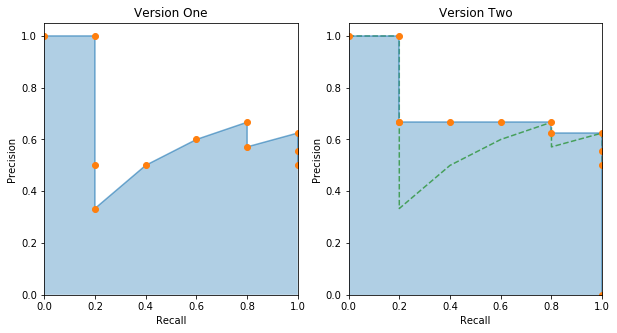

In [10]:
prec1, rec1 = direct_precision_recall_pairs(score, gt)
prec2, rec2 = interpolated_precision_recall_pairs(score, gt)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(rec1, prec1, alpha=0.6)
plt.plot(rec1, prec1, 'o')
plt.fill_between(rec1, prec1, alpha=0.35)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Version One')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.subplot(122)
plt.plot(rec1, prec1, '--g', alpha=0.6)
plt.plot(rec2, prec2, alpha=0.6)
plt.plot(rec2, prec2, 'o')
plt.fill_between(rec2, prec2, alpha=0.35)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Version Two')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()